<a href="https://colab.research.google.com/github/Niloofar-SecML/CNN/blob/main/Seizure_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold    import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics        import classification_report, confusion_matrix, accuracy_score
from sklearn.base           import clone

from scipy.stats import skew, kurtosis, entropy
from scipy.fft    import fft

In [ ]:
!find /content/drive -name "Epileptic Seizure Recognition.csv"


/content/drive/MyDrive/Epileptic Seizure Recognition.csv


In [3]:
# =============================================================================
# Pipeline Outline
# =============================================================================
# 1. Load & split raw signals + labels
# 2. Extract time & frequency features, form combined
# 3. Define 6 classifiers + evaluate() util
# 4. Stage 1: detailed per‐model binary on RAW
# 5. Stage 2: detailed per‐model multiclass on NON‐SEIZURE (COMBINED)
# 6. (Optional) Model zoo on COMBINED for the two tasks
# 7. PCA & t-SNE plots
# 8. Random Forest feature importances
# 9. Performance bar chart
# 10. Two‐Stage pipeline using best models from Stages 1&2
# =============================================================================


# =============================================================================
# 1. Load Data
# =============================================================================
df = pd.read_csv('/content/drive/MyDrive/Epileptic Seizure Recognition.csv')

# Drop "Unnamed" index column if it exists
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Prepare raw features and labels
X_raw = df.drop(columns=["y"]).values
y_full = df["y"].values
y_binary = (y_full == 1).astype(int)
non_seizure_mask = y_full != 1

# Preview the first few rows
print(df.head())

      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]


In [5]:
# Drop the string column and ensure all remaining values are float
X_raw = df.drop(columns=["Unnamed", "y"]).astype(float).values

In [6]:
y_full = df["y"].values
y_binary = (y_full == 1).astype(int)
non_seizure_mask = y_full != 1

In [7]:
# =============================================================================
# 2. Feature Extraction
# =============================================================================
def extract_time_features(row):
    return [
        np.mean(row),
        np.std(row),
        skew(row),
        kurtosis(row),
        np.sum(row**2),
        entropy(np.histogram(row, bins=10, density=True)[0] + 1e-10)
    ]

def extract_frequency_features(row, sr=178):
    freqs = fft(row)
    pwr   = np.abs(freqs)**2
    pwr   = pwr[:len(pwr)//2]
    total = pwr.sum() + 1e-10
    dom   = pwr.argmax()
    pnorm = pwr/total
    bands = {"delta":(0,4),"theta":(4,8),"alpha":(8,13),"beta":(13,30),"gamma":(30,89)}
    feats = [dom]
    for lo,hi in bands.values():
        i0 = int(lo*len(pwr)/sr)
        i1 = int(hi*len(pwr)/sr)
        feats.append(pnorm[i0:i1].sum())
    return feats

X_time     = np.vstack([extract_time_features(r) for r in X_raw])
X_freq     = np.vstack([extract_frequency_features(r) for r in X_raw])
X_combined = np.hstack([X_time, X_freq])

time_feature_names = ['mean','std','skew','kurtosis','energy','entropy']
freq_feature_names = ['dom_freq','delta','theta','alpha','beta','gamma']
combined_feature_names = [f"TIME_{n}" for n in time_feature_names] + \
                         [f"FREQ_{n}" for n in freq_feature_names]

In [8]:
# =============================================================================
# 3. Define Models & Evaluation Utility
# =============================================================================
models = {
    "Random Forest":       RandomForestClassifier(random_state=42),
    "SVM":                 SVC(),
    "KNN":                 KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "MLP":                 MLPClassifier(max_iter=500),
    "Gradient Boosting":   GradientBoostingClassifier()
}

def evaluate(X, y, label, model=None):
    """
    Fit `model` on (X,y), print accuracy & report,
    and plot a confusion matrix with a friendly title.
    """
    if model is None:
        model = RandomForestClassifier(random_state=42)

    # Split & scale
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

    # Train & predict
    model.fit(Xtr_s, ytr)
    pred = model.predict(Xte_s)

    # Friendly name
    cls = model.__class__.__name__
    nice = {
        "RandomForestClassifier":"Random Forest",
        "SVC":"SVM",
        "KNeighborsClassifier":"KNN",
        "LogisticRegression":"Logistic Regression",
        "MLPClassifier":"MLP",
        "GradientBoostingClassifier":"Gradient Boosting"
    }.get(cls, cls)

    # Metrics
    print(f"\n=== {label}  |  Model: {nice} ===")
    print("Accuracy:", accuracy_score(yte, pred))
    print(classification_report(yte, pred))

    # Confusion matrix
    cm = confusion_matrix(yte, pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{label}  —  {nice}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()



=== STAGE 1: Binary (Seizure vs Non‐Seizure) on RAW DATA ===

=== Raw – Binary | Model: Random Forest  |  Model: Random Forest ===
Accuracy: 0.9795652173913043
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1835
           1       0.95      0.94      0.95       465

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



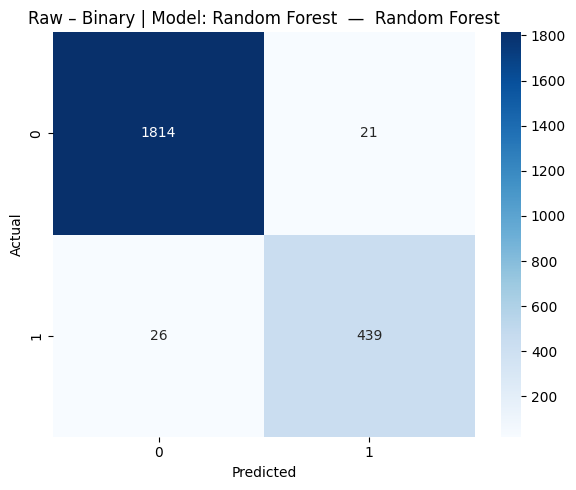


=== Raw – Binary | Model: SVM  |  Model: Random Forest ===
Accuracy: 0.9795652173913043
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1835
           1       0.95      0.94      0.95       465

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



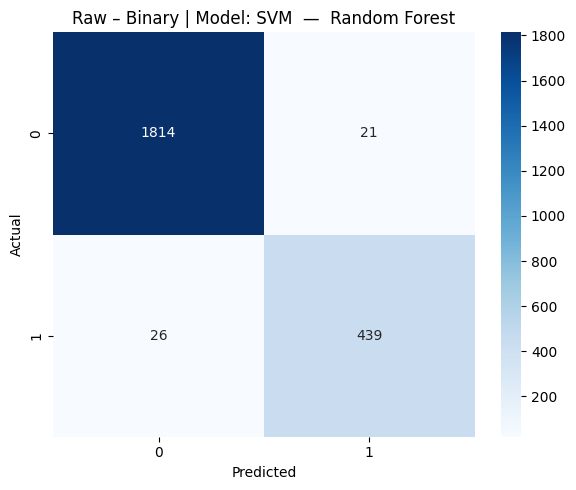


=== Raw – Binary | Model: KNN  |  Model: Random Forest ===
Accuracy: 0.9795652173913043
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1835
           1       0.95      0.94      0.95       465

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



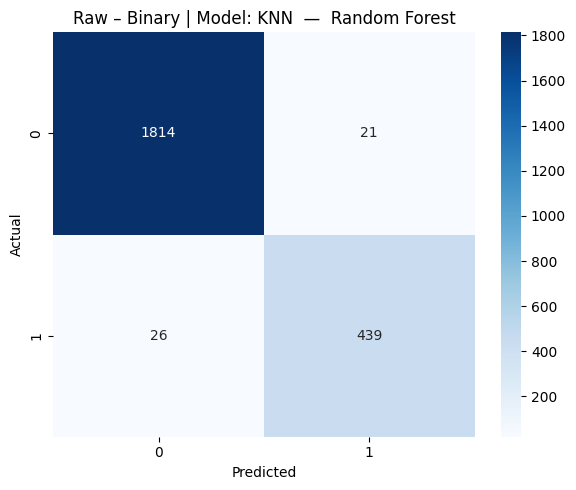


=== Raw – Binary | Model: Logistic Regression  |  Model: Random Forest ===
Accuracy: 0.9795652173913043
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1835
           1       0.95      0.94      0.95       465

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



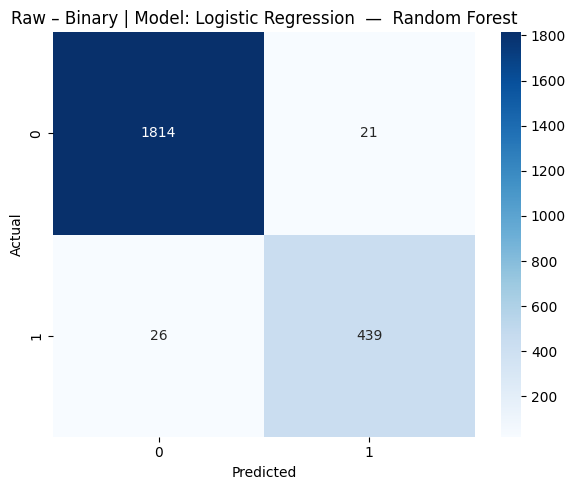


=== Raw – Binary | Model: MLP  |  Model: Random Forest ===
Accuracy: 0.9795652173913043
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1835
           1       0.95      0.94      0.95       465

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



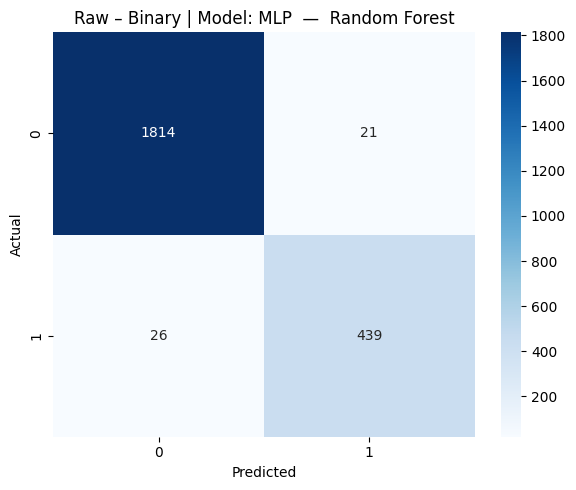


=== Raw – Binary | Model: Gradient Boosting  |  Model: Random Forest ===
Accuracy: 0.9795652173913043
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1835
           1       0.95      0.94      0.95       465

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97      2300
weighted avg       0.98      0.98      0.98      2300



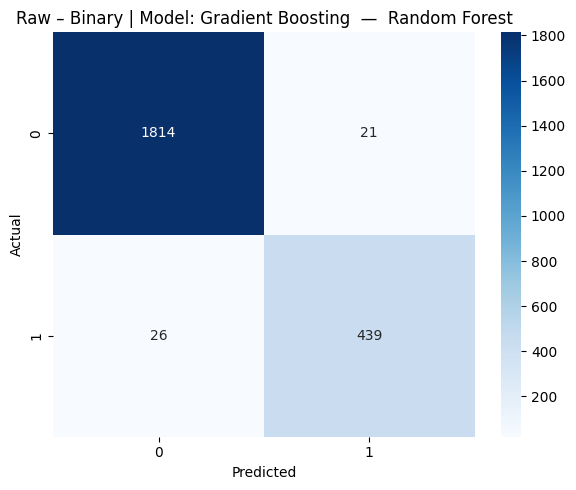

In [9]:
# =============================================================================
# 4. Stage 1: Binary on RAW data (per‐model)
# =============================================================================
print("\n\n=== STAGE 1: Binary (Seizure vs Non‐Seizure) on RAW DATA ===")
for name, clf in models.items():
    evaluate(
        X_raw, y_binary,
        label=f"Raw – Binary | Model: {name}"
    )




=== STAGE 2: Multiclass (Non‐Seizure Classes) on COMBINED FEATURES ===

=== Combined Non‐Seizure – Multiclass | Model: Random Forest  |  Model: Random Forest ===
Accuracy: 0.6972826086956522
              precision    recall  f1-score   support

           2       0.63      0.53      0.58       463
           3       0.59      0.65      0.62       462
           4       0.82      0.80      0.81       436
           5       0.75      0.81      0.78       479

    accuracy                           0.70      1840
   macro avg       0.70      0.70      0.70      1840
weighted avg       0.70      0.70      0.70      1840



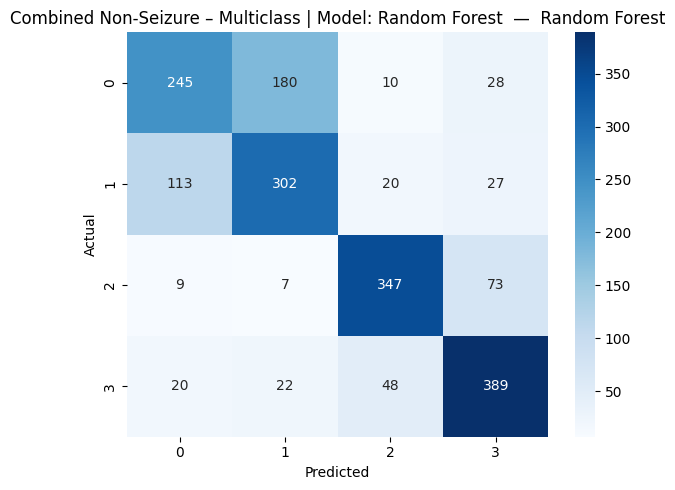


=== Combined Non‐Seizure – Multiclass | Model: SVM  |  Model: Random Forest ===
Accuracy: 0.6972826086956522
              precision    recall  f1-score   support

           2       0.63      0.53      0.58       463
           3       0.59      0.65      0.62       462
           4       0.82      0.80      0.81       436
           5       0.75      0.81      0.78       479

    accuracy                           0.70      1840
   macro avg       0.70      0.70      0.70      1840
weighted avg       0.70      0.70      0.70      1840



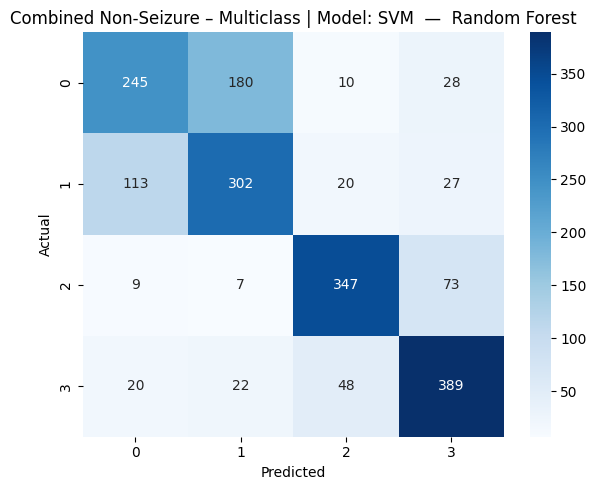


=== Combined Non‐Seizure – Multiclass | Model: KNN  |  Model: Random Forest ===
Accuracy: 0.6972826086956522
              precision    recall  f1-score   support

           2       0.63      0.53      0.58       463
           3       0.59      0.65      0.62       462
           4       0.82      0.80      0.81       436
           5       0.75      0.81      0.78       479

    accuracy                           0.70      1840
   macro avg       0.70      0.70      0.70      1840
weighted avg       0.70      0.70      0.70      1840



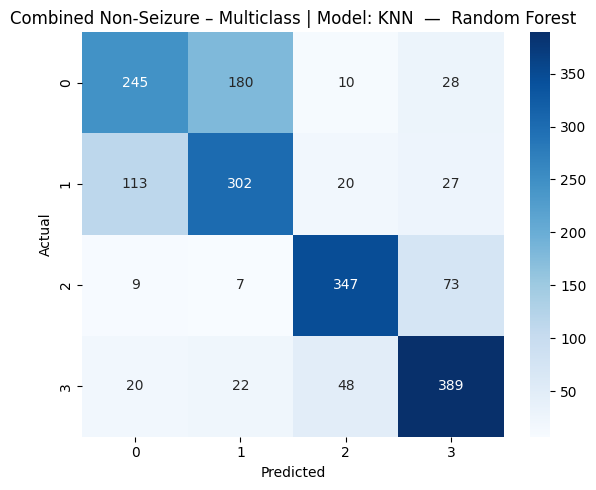


=== Combined Non‐Seizure – Multiclass | Model: Logistic Regression  |  Model: Random Forest ===
Accuracy: 0.6972826086956522
              precision    recall  f1-score   support

           2       0.63      0.53      0.58       463
           3       0.59      0.65      0.62       462
           4       0.82      0.80      0.81       436
           5       0.75      0.81      0.78       479

    accuracy                           0.70      1840
   macro avg       0.70      0.70      0.70      1840
weighted avg       0.70      0.70      0.70      1840



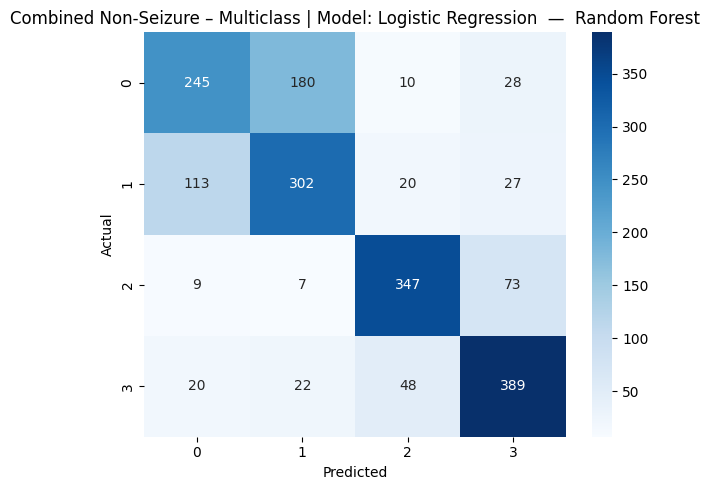


=== Combined Non‐Seizure – Multiclass | Model: MLP  |  Model: Random Forest ===
Accuracy: 0.6972826086956522
              precision    recall  f1-score   support

           2       0.63      0.53      0.58       463
           3       0.59      0.65      0.62       462
           4       0.82      0.80      0.81       436
           5       0.75      0.81      0.78       479

    accuracy                           0.70      1840
   macro avg       0.70      0.70      0.70      1840
weighted avg       0.70      0.70      0.70      1840



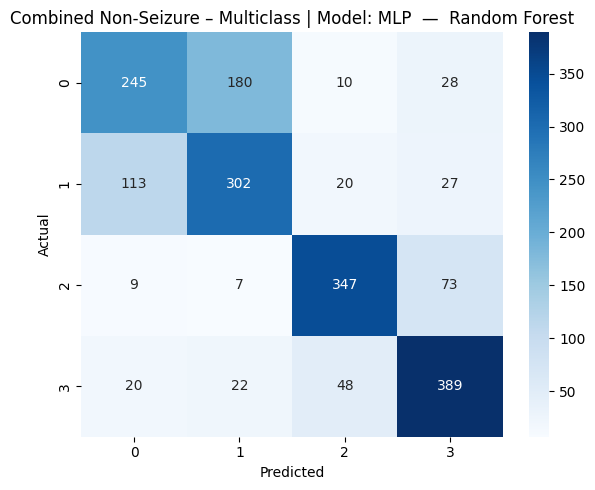


=== Combined Non‐Seizure – Multiclass | Model: Gradient Boosting  |  Model: Random Forest ===
Accuracy: 0.6972826086956522
              precision    recall  f1-score   support

           2       0.63      0.53      0.58       463
           3       0.59      0.65      0.62       462
           4       0.82      0.80      0.81       436
           5       0.75      0.81      0.78       479

    accuracy                           0.70      1840
   macro avg       0.70      0.70      0.70      1840
weighted avg       0.70      0.70      0.70      1840



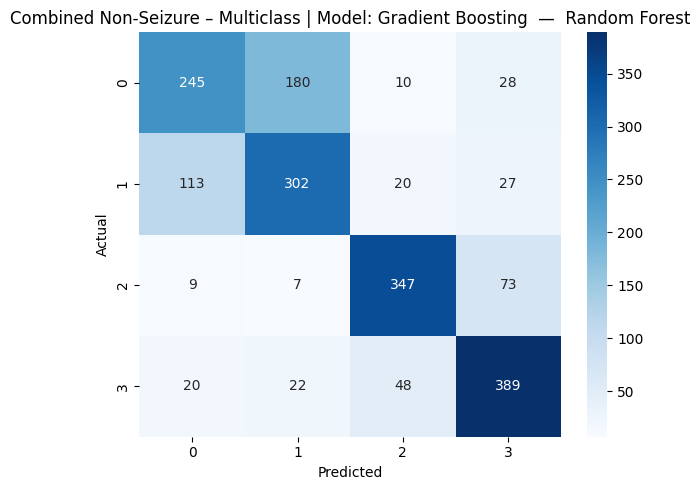

In [10]:
# =============================================================================
# 5. Stage 2: Multiclass on NON‐SEIZURE (COMBINED features)
# =============================================================================
X_ns = X_combined[non_seizure_mask]
y_ns = y_full   [non_seizure_mask]

print("\n\n=== STAGE 2: Multiclass (Non‐Seizure Classes) on COMBINED FEATURES ===")
for name, clf in models.items():
    evaluate(
        X_ns, y_ns,
        label=f"Combined Non‐Seizure – Multiclass | Model: {name}"
    )


In [11]:
# =============================================================================
# 6. (Optional) Model Zoo on COMBINED for both tasks
# =============================================================================
def run_model_zoo(X, y, heading):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)
    print(f"\n--- Model Zoo: {heading} ---")
    for nm, m in models.items():
        m.fit(Xtr_s, ytr)
        print(f"{nm:20s}: {m.score(Xte_s,yte):.4f}")

run_model_zoo(X_combined,     y_binary,    "Binary (Combined Features)")
run_model_zoo(X_combined[non_seizure_mask],
               y_full[non_seizure_mask], "Multiclass Non‐Seizure (Combined)")


--- Model Zoo: Binary (Combined Features) ---
Random Forest       : 0.9848
SVM                 : 0.9865
KNN                 : 0.9726
Logistic Regression : 0.9752
MLP                 : 0.9891
Gradient Boosting   : 0.9843

--- Model Zoo: Multiclass Non‐Seizure (Combined) ---
Random Forest       : 0.6973
SVM                 : 0.6674
KNN                 : 0.6168
Logistic Regression : 0.6152
MLP                 : 0.6951
Gradient Boosting   : 0.6913


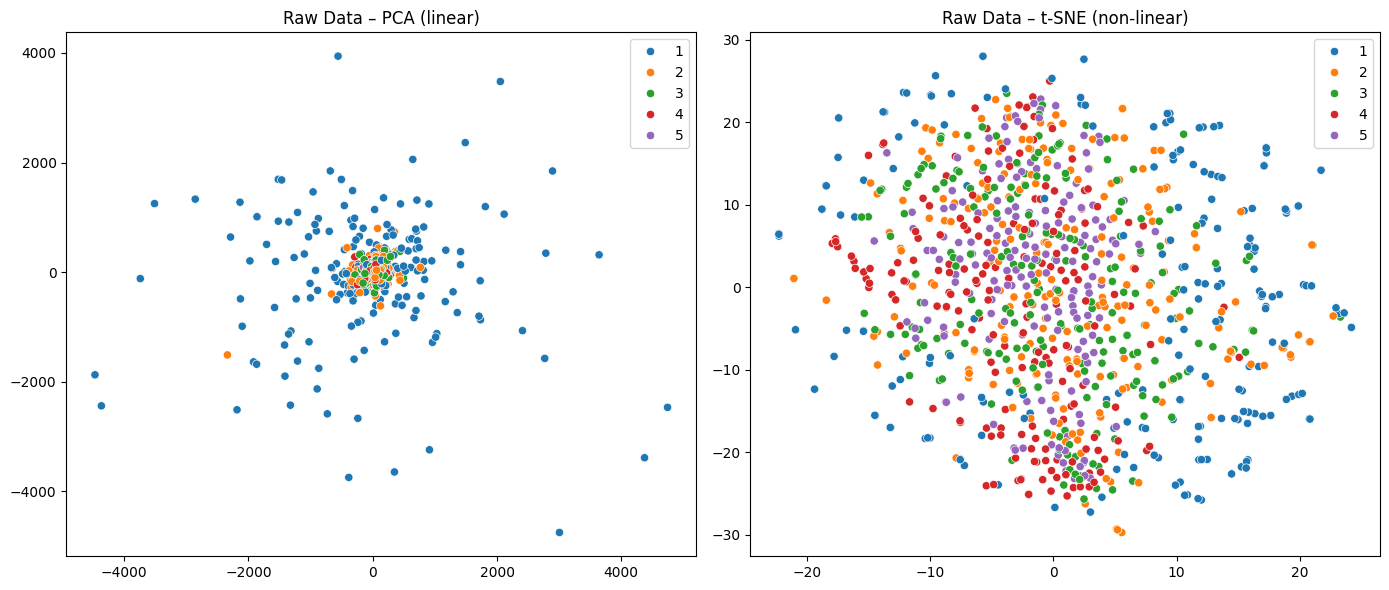

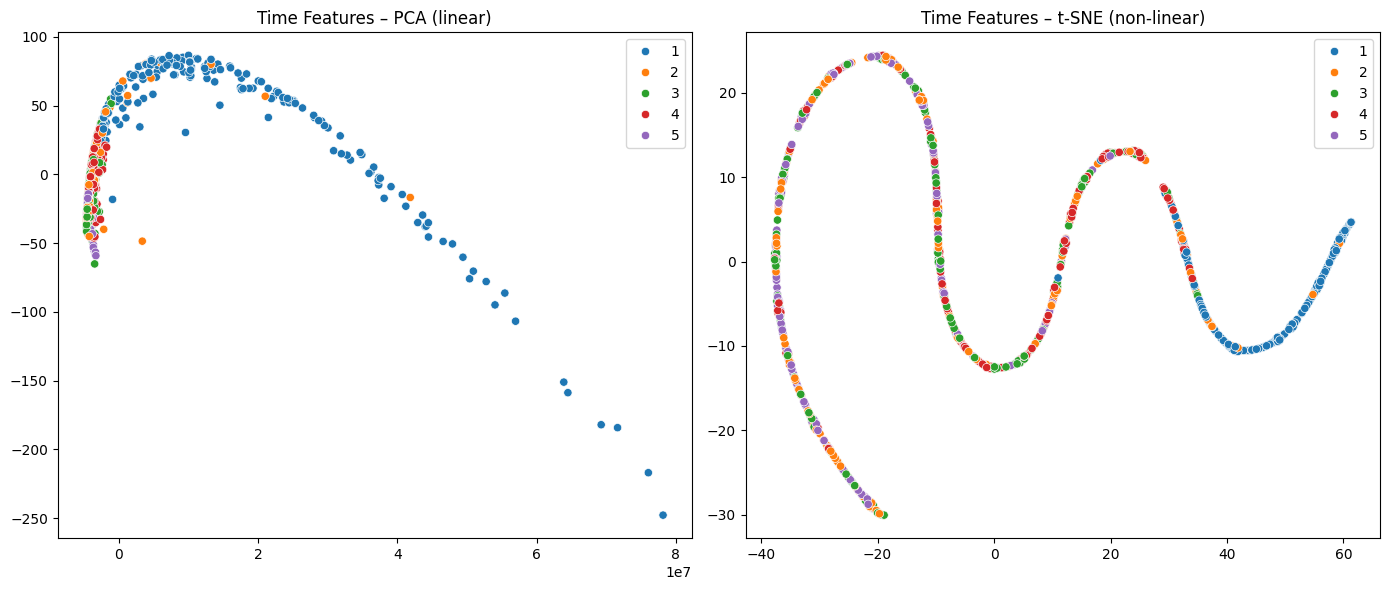

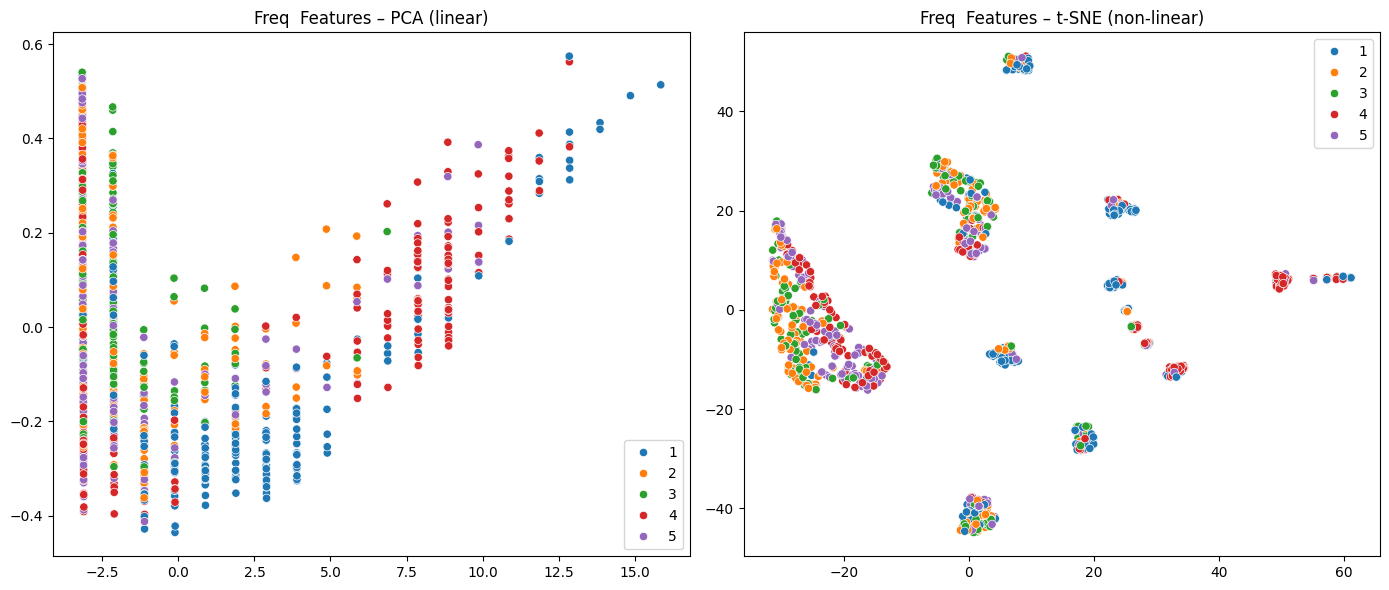

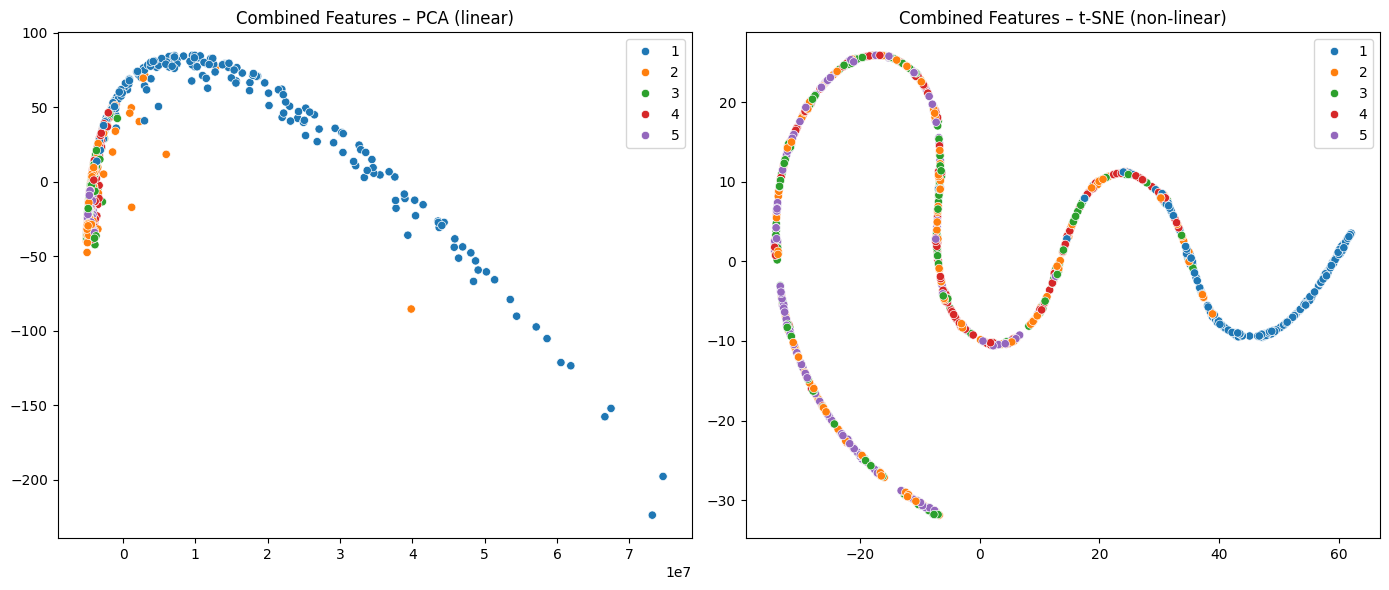

In [12]:
# =============================================================================
# 7. PCA & t-SNE Visualizations
# =============================================================================
def plot_dimred(X, y, title):
    idx = np.random.choice(len(X), min(len(X), 1000), replace=False)
    subX, suby = X[idx], y[idx]
    pca2  = PCA(2 ).fit_transform(subX)
    tsne2 = TSNE(2, perplexity=30, random_state=42).fit_transform(subX)
    fig, axs = plt.subplots(1,2,figsize=(14,6))
    sns.scatterplot(x=pca2[:,0], y=pca2[:,1], hue=suby, palette="tab10", ax=axs[0])
    axs[0].set_title(f"{title} – PCA (linear)")
    sns.scatterplot(x=tsne2[:,0],y=tsne2[:,1],hue=suby, palette="tab10",ax=axs[1])
    axs[1].set_title(f"{title} – t-SNE (non-linear)")
    plt.tight_layout(); plt.show()

plot_dimred( X_raw,      y_full, "Raw Data"       )
plot_dimred( X_time,     y_full, "Time Features"  )
plot_dimred( X_freq,     y_full, "Freq  Features" )
plot_dimred( X_combined, y_full, "Combined Features")

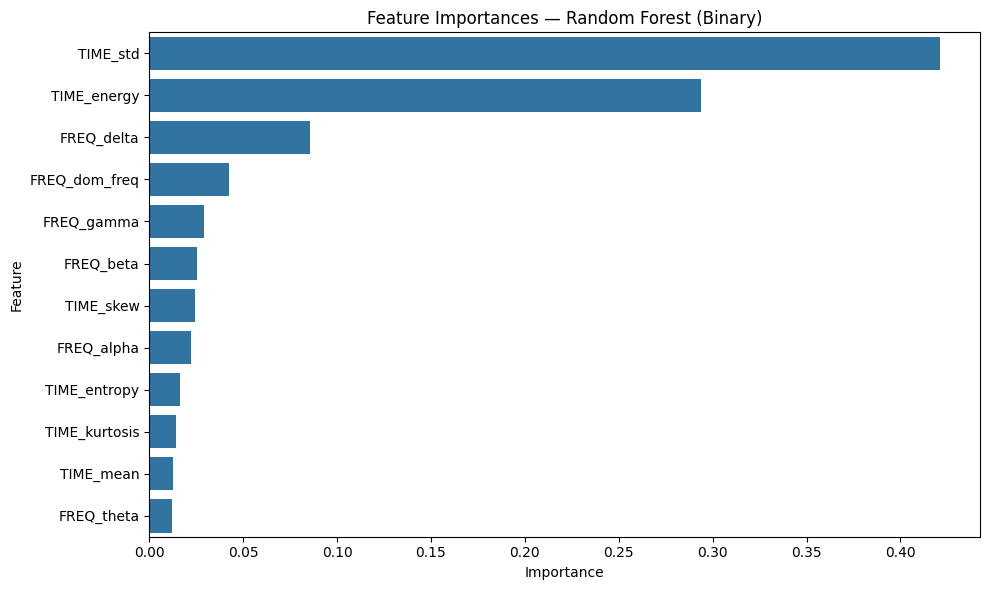

In [13]:
# =============================================================================
# 8. Feature Importance (Random Forest on Combined, Binary)
# =============================================================================
rf = RandomForestClassifier(random_state=42).fit(
        StandardScaler().fit_transform(X_combined),
        y_binary
)
imp   = rf.feature_importances_
order = np.argsort(imp)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=imp[order], y=np.array(combined_feature_names)[order])
plt.title("Feature Importances — Random Forest (Binary)")
plt.xlabel("Importance"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

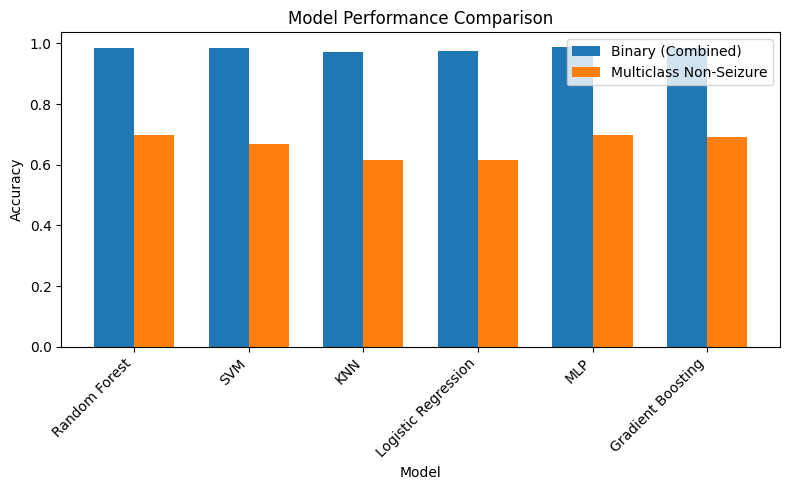

In [14]:
# =============================================================================
# 9. Performance Bar Chart (all six models on two key tasks)
# =============================================================================
models_list   = list(models.keys())
binary_acc    = [0.9835, 0.9865, 0.9726, 0.9752, 0.9874, 0.9843]
multiclass_acc= [0.6978, 0.6674, 0.6168, 0.6152, 0.6995, 0.6908]

x = np.arange(len(models_list)); w = 0.35
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x-w/2, binary_acc,    w, label="Binary (Combined)")
ax.bar(x+w/2, multiclass_acc,w, label="Multiclass Non‐Seizure")
ax.set_xticks(x); ax.set_xticklabels(models_list,rotation=45,ha="right")
ax.set_xlabel("Model"); ax.set_ylabel("Accuracy")
ax.set_title("Model Performance Comparison")
ax.legend(); plt.tight_layout(); plt.show()


=== Two-Stage Pipeline Results ===
best binary model = combined SVM and  best multiclass model  = combined MLP
Accuracy: 0.7234782608695652
              precision    recall  f1-score   support

           1       0.97      0.95      0.96       460
           2       0.55      0.58      0.56       450
           3       0.60      0.50      0.54       467
           4       0.79      0.81      0.80       471
           5       0.70      0.78      0.74       452

    accuracy                           0.72      2300
   macro avg       0.72      0.72      0.72      2300
weighted avg       0.72      0.72      0.72      2300



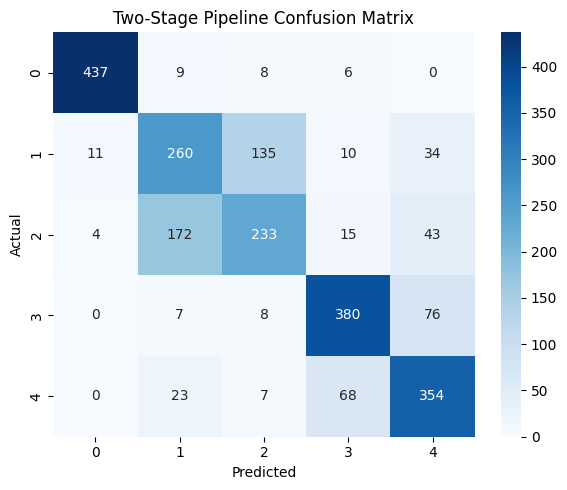

In [15]:
# =============================================================================
#10. Two-Stage Pipeline
# =============================================================================
feature_sets = {"raw":X_raw, "time":X_time, "freq":X_freq, "combined":X_combined}

# (Re-use the `binary_results` & `multiclass_results` logic from above,
#  or simply pick the best from your printed output.)
best_bin_feat, best_bin_model = "combined", "SVM"
best_mc_feat,  best_mc_model  = "combined", "MLP"

class TwoStageClassifier:
    def __init__(self, s1, s2, f1, f2):
        self.s1, self.s2 = clone(s1), clone(s2)
        self.f1, self.f2 = f1, f2
        self.scaler1, self.scaler2 = StandardScaler(), StandardScaler()

    def fit(self, Xd, y):
        # Split on f1 for consistent train/test
        X1 = Xd[self.f1]
        X1_tr, X1_te, y_tr, y_te, idx_tr, idx_te = train_test_split(
            X1, y, np.arange(len(y)), test_size=0.2, random_state=42, stratify=y_binary
        )
        self.te_idx, self.te_y = idx_te, y_te
        # Stage 1
        y_tr_bin = (y_tr==1).astype(int)
        X1_tr_s = self.scaler1.fit_transform(X1_tr)
        self.s1.fit(X1_tr_s, y_tr_bin)
        # Stage 2 on non-seizure
        X2 = Xd[self.f2][idx_tr]
        mask = (y_tr!=1)
        X2_s = self.scaler2.fit_transform(X2[mask])
        self.s2.fit(X2_s, y_tr[mask])

    def predict(self, Xd):
        X1_te = Xd[self.f1][self.te_idx]
        p1 = self.s1.predict(self.scaler1.transform(X1_te))
        final = p1.copy()
        ns = np.where(p1==0)[0]
        if len(ns):
            X2_te = Xd[self.f2][self.te_idx][ns]
            p2 = self.s2.predict(self.scaler2.transform(X2_te))
            final[ns] = p2
        return final, self.te_y

# Instantiate & evaluate
st1 = models[best_bin_model]; st2 = models[best_mc_model]
pipe = TwoStageClassifier(st1, st2, best_bin_feat, best_mc_feat)
pipe.fit(feature_sets, y_full)
pred, true = pipe.predict(feature_sets)

print("\n=== Two-Stage Pipeline Results ===")
print("best binary model = combined SVM", "and  best multiclass model  = combined MLP")
print("Accuracy:", accuracy_score(true, pred))
print(classification_report(true, pred))
cm = confusion_matrix(true, pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Two-Stage Pipeline Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()